#Chapter 5. Text Generation
One of the most uncanny features of transformer-based language models is their ability to generate text that is almost indistinguishable from text written by humans. A famous example is OpenAI’s GPT-2, which when given the prompt:1

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

was able to generate a compelling news article about talking unicorns:

The scientist named the population, after their distinctive horn, Ovid’s Unicorn. These four-horned, silver-white unicorns were previously unknown to science. Now, after almost two centuries, the mystery of what sparked this odd phenomenon is finally solved. Dr. Jorge Pérez, an evolutionary biologist from the University of La Paz, and several companions, were exploring the Andes Mountains when they found a small valley, with no other animals or humans. Pérez noticed that the valley had what appeared to be a natural fountain, surrounded by two peaks of rock and silver snow. Pérez and the others then ventured further into the valley. “By the time we reached the top of one peak, the water looked blue, with some crystals on top,” said Pérez. Pérez and his friends were astonished to see the unicorn herd. These creatures could be seen from the air without having to move too much to see them—they were so close they could touch their horns. While examining these bizarre creatures the scientists discovered that the creatures also spoke some fairly regular English …

What makes this example so remarkable is that it was generated without any explicit supervision! By simply learning to predict the next word in the text of millions of web pages, GPT-2 and its more powerful descendants like GPT-3 are able to acquire a broad set of skills and pattern recognition abilities that can be activated with different kinds of input prompts. Figure 5-1 shows how language models are sometimes exposed during pretraining to sequences of tasks where they need to predict the following tokens based on the context alone, like addition, unscrambling words, and translation. This allows them to transfer this knowledge effectively during fine-tuning or (if the model is large enough) at inference time. These tasks are not chosen ahead of time, but occur naturally in the huge corpora used to train billion-parameter language models.

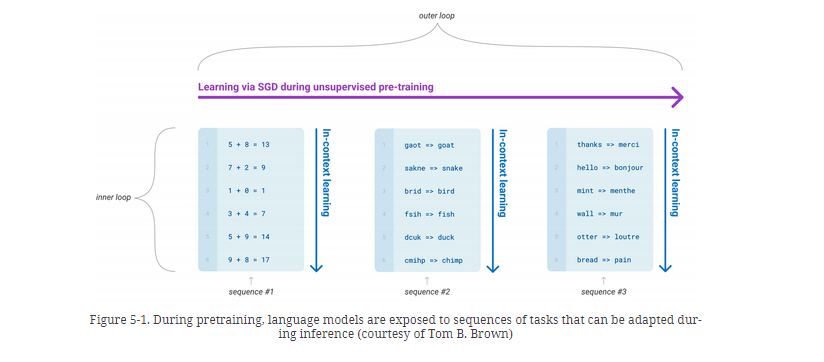

The ability of transformers to generate realistic text has led to a diverse range of applications, like InferKit, Write With Transformer, AI Dungeon, and conversational agents like Google’s Meena that can even tell corny jokes, as shown in Figure 5-2!2

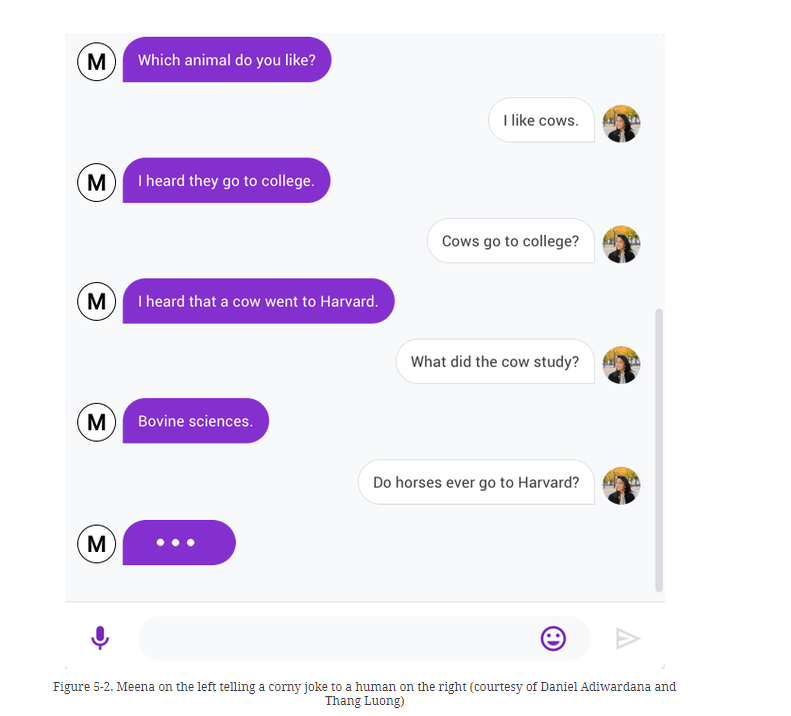

In this chapter we’ll use GPT-2 to illustrate how text generation works for language models and explore how different decoding strategies impact the generated texts.

#The Challenge with Generating Coherent Text
So far in this book, we have focused on tackling NLP tasks via a combination of pretraining and supervised fine-tuning. As we’ve seen, for task-specific heads like sequence or token classification, generating predictions is fairly straightforward; the model produces some logits and we either take the maximum value to get the predicted class, or apply a softmax function to obtain the predicted probabilities per class. By contrast, converting the model’s probabilistic output to text requires a decoding method, which introduces a few challenges that are unique to text generation:

The decoding is done iteratively and thus involves significantly more compute than simply passing inputs once through the forward pass of a model.

The quality and diversity of the generated text depend on the choice of decoding method and associated hyperparameters.

To understand how this decoding process works, let’s start by examining how GPT-2 is pretrained and subsequently applied to generate text.

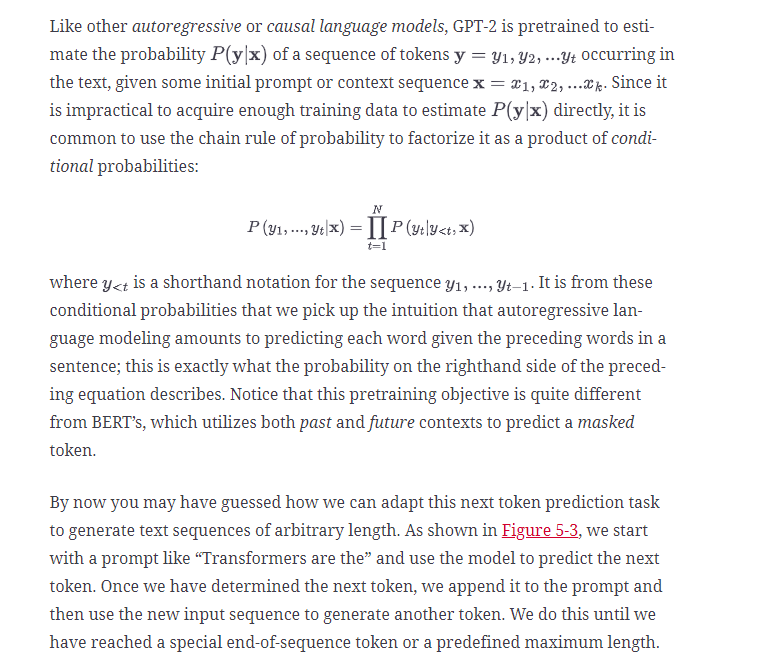

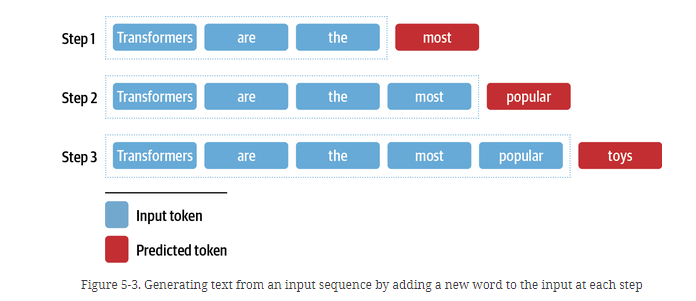

#NOTE
Since the output sequence is conditioned on the choice of input prompt, this type of text generation is often called conditional text generation.

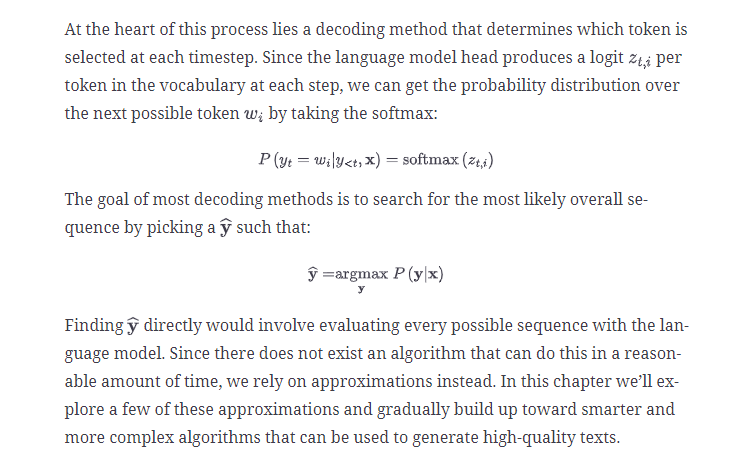

#Greedy Search Decoding
The simplest decoding method to get discrete tokens from a model’s continuous output is to greedily select the token with the highest probability at each timestep:

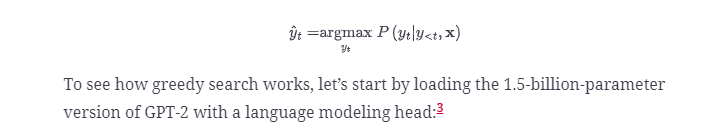

In [1]:
!pip install transformers

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Now let’s generate some text! Although nlpt_pin01 Transformers provides a generate() function for autoregressive models like GPT-2, we’ll implement this decoding method ourselves to see what goes on under the hood. To warm up, we’ll take the same iterative approach shown in Figure 5-3: we’ll use “Transformers are the” as the input prompt and run the decoding for eight timesteps. At each timestep, we pick out the model’s logits for the last token in the prompt and wrap them with a softmax to get a probability distribution. We then pick the next token with the highest probability, add it to the input sequence, and run the process again. The following code does the job, and also stores the five most probable tokens at each timestep so we can visualize the alternatives:

In [ ]:
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

With this simple method we were able to generate the sentence “Transformers are the most popular toy line in the world”. Interestingly, this indicates that GPT-2 has internalized some knowledge about the Transformers media franchise, which was created by two toy companies (Hasbro and Takara Tomy). We can also see the other possible continuations at each step, which shows the iterative nature of text generation. Unlike other tasks such as sequence classification where a single forward pass suffices to generate the predictions, with text generation we need to decode the output tokens one at a time.

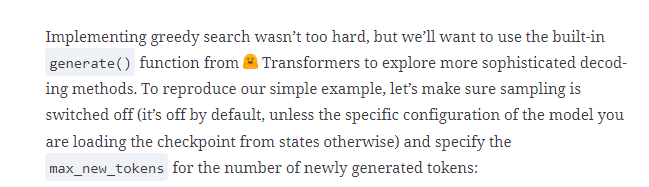

In [ ]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

Now let’s try something a bit more interesting: can we reproduce the unicorn story from OpenAI? As we did previously, we’ll encode the prompt with the tokenizer, and we’ll specify a larger value for max_length to generate a longer sequence of text:

In [ ]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length,
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

Well, the first few sentences are quite different from the OpenAI example and amusingly involve different universities being credited with the discovery! We can also see one of the main drawbacks with greedy search decoding: it tends to produce repetitive output sequences, which is certainly undesirable in a news article. This is a common problem with greedy search algorithms, which can fail to give you the optimal solution; in the context of decoding, they can miss word sequences whose overall probability is higher just because high-probability words happen to be preceded by low-probability ones.

Fortunately, we can do better—let’s examine a popular method known as beam search decoding.

#NOTE
Although greedy search decoding is rarely used for text generation tasks that require diversity, it can be useful for producing short sequences like arithmetic where a deterministic and factually correct output is preferred.4 For these tasks, you can condition GPT-2 by providing a few line-separated examples in the format "5 + 8 => 13 \n 7 + 2 => 9 \n 1 + 0 =>" as the input prompt.

#Beam Search Decoding
Instead of decoding the token with the highest probability at each step, beam search keeps track of the top-b most probable next tokens, where b is referred to as the number of beams or partial hypotheses. The next set of beams are chosen by considering all possible next-token extensions of the existing set and selecting the b most likely extensions. The process is repeated until we reach the maximum length or an EOS token, and the most likely sequence is selected by ranking the b beams according to their log probabilities. An example of beam search is shown in Figure 5-4.

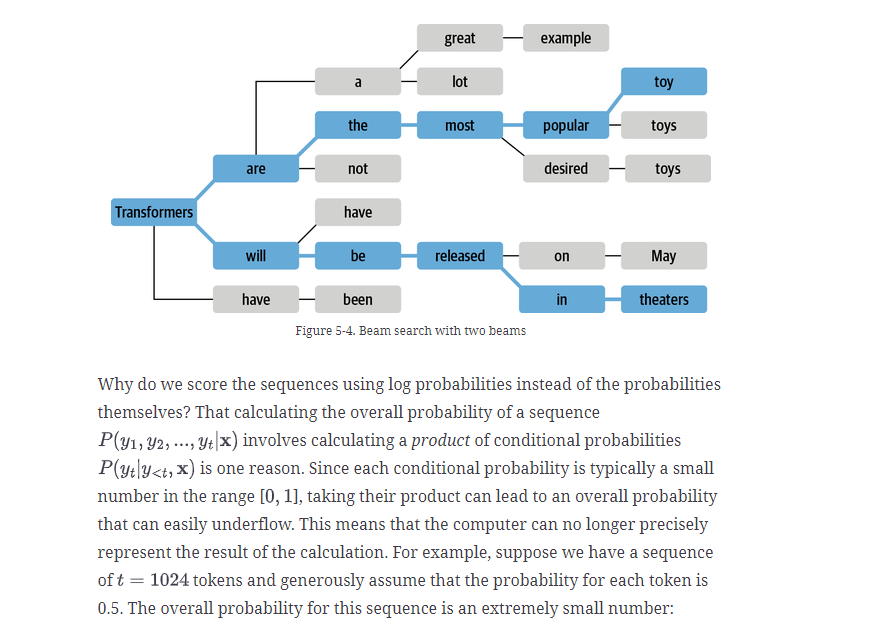

In [ ]:
0.5 ** 1024

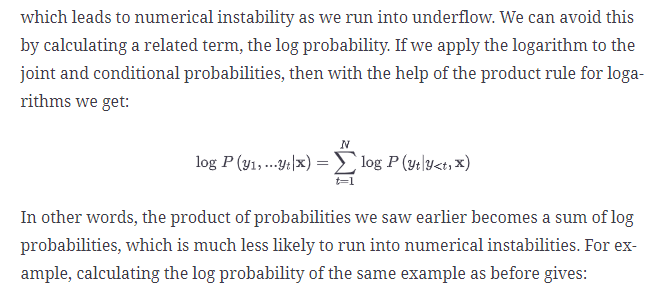

In [ ]:
import numpy as np

sum([np.log(0.5)] * 1024)

This is a number we can easily deal with, and this approach still works for much smaller numbers. Since we only want to compare relative probabilities, we can do this directly with log probabilities.

Let’s calculate and compare the log probabilities of the texts generated by greedy and beam search to see if beam search can improve the overall probability. Since nlpt_pin01 Transformers models return the unnormalized logits for the next token given the input tokens, we first need to normalize the logits to create a probability distribution over the whole vocabulary for each token in the sequence. We then need to select only the token probabilities that were present in the sequence. The following function implements these steps:

In [ ]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

This gives us the log probability for a single token, so to get the total log probability of a sequence we just need to sum the log probabilities for each token:

In [ ]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

Note that we ignore the log probabilities of the input sequence because they are not generated by the model. We can also see that it is important to align the logits and the labels; since the model predicts the next token, we do not get a logit for the first label, and we don’t need the last logit because we don’t have a ground truth token for it.

Let’s use these functions to first calculate the sequence log probability of the greedy decoder on the OpenAI prompt:

In [ ]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

Now let’s compare this to a sequence that is generated with beam search. To activate beam search with the generate() function we just need to specify the number of beams with the num_beams parameter. The more beams we choose, the better the result potentially gets; however, the generation process becomes much slower since we generate parallel sequences for each beam:

In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

We can see that we get a better log probability (higher is better) with beam search than we did with simple greedy decoding. However, we can see that beam search also suffers from repetitive text. One way to address this is to impose an n-gram penalty with the no_repeat_ngram_size parameter that tracks which n-grams have been seen and sets the next token probability to zero if it would produce a previously seen n-gram:

In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

This isn’t too bad! We’ve managed to stop the repetitions, and we can see that despite producing a lower score, the text remains coherent. Beam search with n-gram penalty is a good way to find a trade-off between focusing on high-probability tokens (with beam search) while reducing repetitions (with n-gram penalty), and it’s commonly used in applications such as summarization or machine translation where factual correctness is important. When factual correctness is less important than the diversity of generated output, for instance in open-domain chitchat or story generation, another alternative to reduce repetitions while improving diversity is to use sampling. Let’s round out our exploration of text generation by examining a few of the most common sampling methods.

Sampling Methods
The simplest sampling method is to randomly sample from the probability distribution of the model’s outputs over the full vocabulary at each timestep:

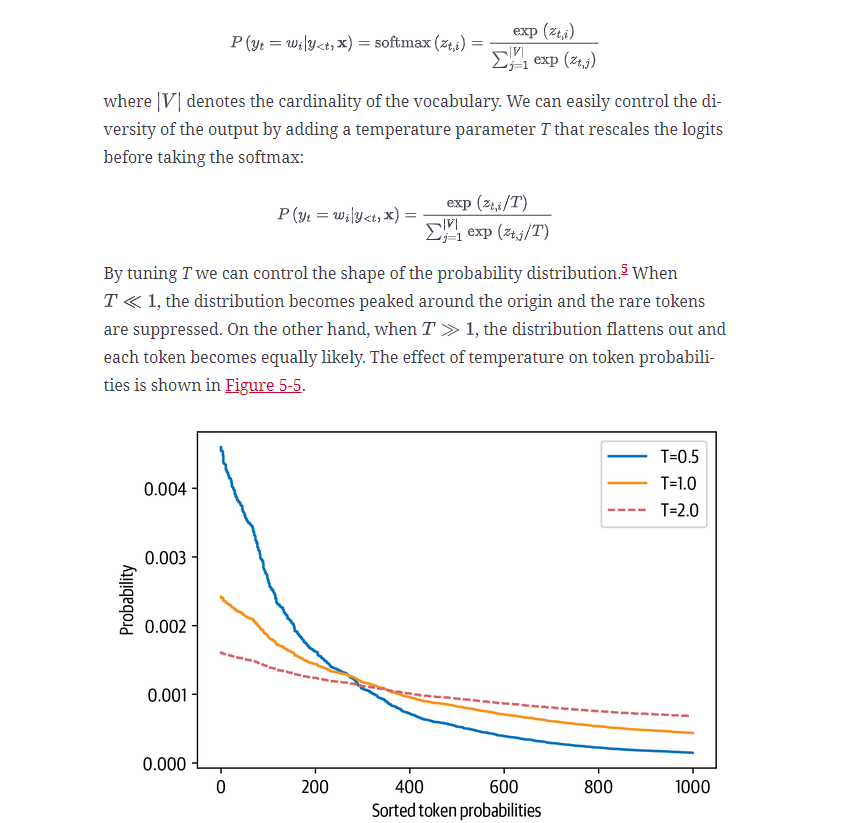

Figure 5-5. Distribution of randomly generated token probabilities for three selected temperatures

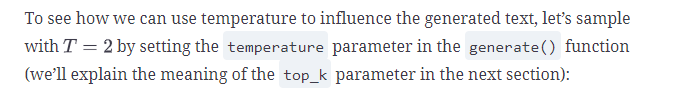

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

We can clearly see that a high temperature has produced mostly gibberish; by accentuating the rare tokens, we’ve caused the model to create strange grammar and quite a few made-up words! Let’s see what happens if we cool down the temperature:

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

This is significantly more coherent, and even includes a quote from yet another university being credited with the discovery! The main lesson we can draw from temperature is that it allows us to control the quality of the samples, but there’s always a trade-off between coherence (low temperature) and diversity (high temperature) that one has to tune to the use case at hand.

Another way to adjust the trade-off between coherence and diversity is to truncate the distribution of the vocabulary. This allows us to adjust the diversity freely with the temperature, but in a more limited range that excludes words that would be too strange in the context (i.e., low-probability words). There are two main ways to do this: top-k and nucleus (or top-p) sampling. Let’s take a look.

#Top-k and Nucleus Sampling

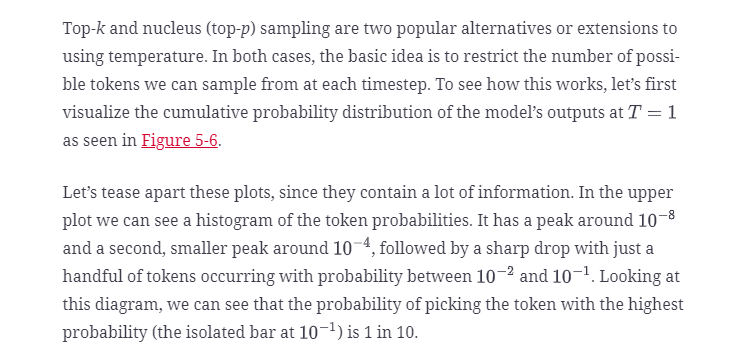

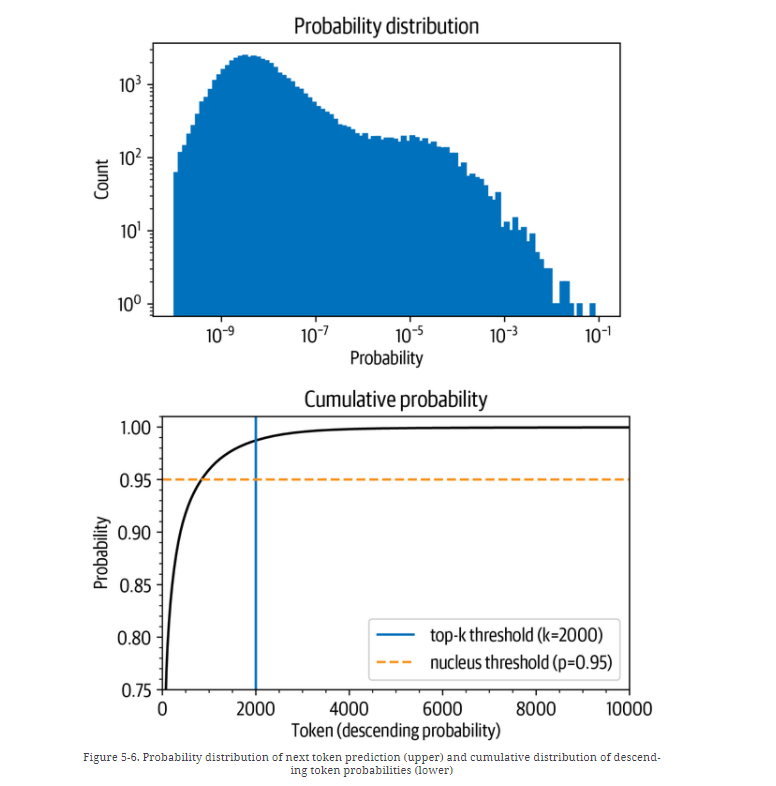

In the lower plot, we’ve ordered the tokens by descending probability and calculated the cumulative sum of the first 10,000 tokens (in total, there are 50,257 tokens in GPT-2’s vocabulary). The curved line represents the probability of picking any of the preceding tokens. For example, there is roughly a 96% chance of picking any of the 1,000 tokens with the highest probability. We see that the probability rises quickly above 90% but saturates to close to 100% only after several thousand tokens. The plot shows that there is a 1 in 100 chance of not picking any of the tokens that are not even in the top 2,000.

Although these numbers might appear small at first sight, they become important because we sample once per token when generating text. So even if there is only a 1 in 100 or 1,000 chance, if we sample hundreds of times there is a significant chance of picking an unlikely token at some point—and picking such tokens when sampling can badly influence the quality of the generated text. For this reason, we generally want to avoid these very unlikely tokens. This is where top-k and top-p sampling come into play.

The idea behind top-k sampling is to avoid the low-probability choices by only sampling from the k tokens with the highest probability. This puts a fixed cut on the long tail of the distribution and ensures that we only sample from likely choices. Going back to Figure 5-6, top-k sampling is equivalent to defining a vertical line and sampling from the tokens on the left. Again, the generate() function provides an easy method to achieve this with the top_k argument:

In [ ]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

This is arguably the most human-looking text we’ve generated so far. But how do we choose k? The value of k is chosen manually and is the same for each choice in the sequence, independent of the actual output distribution. We can find a good value for k by looking at some text quality metrics, which we will explore in the next chapter—but that fixed cutoff might not be very satisfactory.

An alternative is to use a dynamic cutoff. With nucleus or top-p sampling, instead of choosing a fixed cutoff value, we set a condition of when to cut off. This condition is when a certain probability mass in the selection is reached. Let’s say we set that value to 95%. We then order all tokens in descending order by probability and add one token after another from the top of the list until the sum of the probabilities of the selected tokens is 95%. Returning to Figure 5-6, the value for p defines a horizontal line on the cumulative sum of probabilities plot, and we sample only from tokens below the line. Depending on the output distribution, this could be just one (very likely) token or a hundred (more equally likely) tokens. At this point, you are probably not surprised that the generate() function also provides an argument to activate top-p sampling. Let’s try it out:

In [ ]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

Top-p sampling has also produced a coherent story, and this time with a new twist about migrations from Australia to South America. You can even combine the two sampling approaches to get the best of both worlds. Setting top_k=50 and top_p=0.9 corresponds to the rule of choosing tokens with a probability mass of 90%, from a pool of at most 50 tokens.

#NOTE
We can also apply beam search when we use sampling. Instead of selecting the next batch of candidate tokens greedily, we can sample them and build up the beams in the same way.

#Which Decoding Method Is Best?
Unfortunately, there is no universally “best” decoding method. Which approach is best will depend on the nature of the task you are generating text for. If you want your model to perform a precise task like arithmetic or providing an answer to a specific question, then you should lower the temperature or use deterministic methods like greedy search in combination with beam search to guarantee getting the most likely answer. If you want the model to generate longer texts and even be a bit creative, then you should switch to sampling methods and increase the temperature or use a mix of top-k and nucleus sampling.

Conclusion
In this chapter we looked at text generation, which is a very different task from the NLU tasks we encountered previously. Generating text requires at least one forward pass per generated token, and even more if we use beam search. This makes text generation computationally demanding, and one needs the right infrastructure to run a text generation model at scale. In addition, a good decoding strategy that transforms the model’s output probabilities into discrete tokens can improve the text quality. Finding the best decoding strategy requires some experimentation and a subjective evaluation of the generated texts.

In practice, however, we don’t want to make these decisions based on gut feeling alone! Like with other NLP tasks, we should choose a model performance metric that reflects the problem we want to solve. Unsurprisingly, there are a wide range of choices, and we will encounter the most common ones in the next chapter, where we have a look at how to train and evaluate a model for text summarization. Or, if you can’t wait to learn how to train a GPT-type model from scratch, you can skip right to Chapter 10, where we collect a large dataset of code and then train an autoregressive language model on it.

1 This example comes from OpenAI’s blog post on GPT-2.

2 However, as Delip Rao points out, whether Meena intends to tell corny jokes is a subtle question.

3 If you run out of memory on your machine, you can load a smaller GPT-2 version by replacing model_name = "gpt-xl" with model_name = "gpt".

4 N.S. Keskar et al., “CTRL: A Conditional Transformer Language Model for Controllable Generation”, (2019).

5 If you know some physics, you may recognize a striking resemblance to the Boltzmann distribution.